<a href="https://colab.research.google.com/github/sellinkaya/Medical_Insurance_Payment_Project/blob/main/Health_Insurance_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GİRİŞ**

**Amaç** : Bu projede, sağlık sigortası verilerini kullanarak bireylerin "claim" yani talep tutarlarını tahmin etmeye çalıştık. Hedef değişkenimiz log dönüşümüne tabi tutulmuş claim_log değişkenidir. Bu sayede uç değerlerin etkisi azaltılarak daha stabil ve anlamlı modeller elde edilmiştir.



**Kullanılan Modeller ve Sonuçlar**

Modeller, test verisi üzerinden gerçek değerler (log dönüşümünden geri çevrilmiş) ile karşılaştırıldı. Değerlendirme metriklerimiz:

**MAE (Ortalama Mutlak Hata):**Tahminlerin ne kadar sapma gösterdiğini ifade eder. Düşük olması istenir.

**RMSE (Kök Ortalama Kare Hata):** Büyük hataları daha çok cezalandırır. Düşük olması istenir.

**R² (Determinasyon Katsayısı):** Modelin veriyi ne kadar iyi açıkladığını gösterir. 1'e yakın olması idealdir.

In [48]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

**Gerekli Kütüphanelerin İçe Aktarılması**

Veri işleme için pandas ve numpy kullanılıyor.
Veri görselleştirme için matplotlib ve seaborn tercih edildi.
Makine öğrenmesi modelleri ve değerlendirme metrikleri için scikit-learn ve XGBoost kütüphaneleri dahil edildi.

In [49]:
from google.colab import files
uploaded = files.upload()

# 1. Veri Yükleme
df = pd.read_csv("healthinsurance.csv", sep=";")


Saving healthinsurance.csv to healthinsurance (3).csv


 **Veri Setinin Yüklenmesi**

Sağlık sigortası verisi CSV formatında yüklendi.
sep=";" parametresi verideki sütunların noktalı virgülle ayrıldığını belirtiyor.

In [50]:
# 2. Eksik Değer Temizliği
numerical_cols = df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Şimdi tekrar kontrol et
print(df.isnull().sum())  # Hepsi 0 olmalı

age                    0
sex                    0
weight                 0
bmi                    0
hereditary diseases    0
no of dependents       0
smoker                 0
city                   0
bloodpressure          0
diabetes               0
regular ex             0
job title              0
claim                  0
dtype: int64


**Eksik Değerlerin Temizlenmesi**

Sayısal sütunlardaki eksik değerler, sütunların medyanı ile dolduruldu.
Medyan seçimi, uç değerlerin etkisini azaltmak için ortalamadan daha sağlam bir merkez ölçüsüdür.
Eksik veriler, modellerin başarısını düşürdüğü için temizlenmelidir.

In [51]:
# 3. Kategorik Verileri Dönüştürme
df = pd.get_dummies(df, columns=[
    'sex', 'hereditary diseases', 'smoker', 'city',
    'job title', 'regular ex'
], drop_first=True)

**Kategorik Değişkenlerin Sayısal Formata Dönüştürülmesi**

Makine öğrenmesi algoritmaları sayısal verilerle çalıştığı için kategorik değişkenler “One-Hot Encoding” ile sayısallaştırıldı.

drop_first=True ile bir kategori referans alınarak kolonların fazlalığı önlendi (dummy variable trap engellendi).

In [52]:
# 4. Log Dönüşümlü Değişken Oluşturma (Modelleme İçin)
df['claim_log'] = np.log1p(df['claim'])   # log1p: log(1+x)

In [53]:
# 5. Hedef ve Özellik Ayırma (Log Dönüşümüyle)
X = df.drop(columns=['claim', 'claim_log'])  # claim orijinali çıkarılır
y = df['claim_log']  # log dönüşümlü değer hedef olarak alınır



**Hedef Değişkenin Logaritmik Dönüşümü**

claim değişkeni genellikle yüksek değerlerde uç noktalar (outliers) içerir.

Logaritmik dönüşüm (log1p) ile dağılım daha simetrik hale getirilerek modelin aşırı büyük değerlerden etkilenmesi azaltılır.

log1p fonksiyonu log(1+x) şeklinde olup, sıfır değerlerde hata oluşmasını engeller.

In [54]:
# 6. Eğitim ve Test Ayrımı
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Hedef ve Özelliklerin Ayrılması**

X değişkeni modelin öğrenmesi için kullanılacak özellikler (bağımsız değişkenler).
y hedef değişkendir, burada log dönüşümlü claim_log seçildi.
Orijinal claim sütunu modelden çıkarıldı çünkü log dönüşümlü hedef kullanılacak.


In [55]:
# 7. Değerlendirme Fonksiyonu
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred_log = model.predict(X_test)
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred_log)

    print(f"\n{name}")
    print("-" * len(name))
    print("MAE:", mean_absolute_error(y_test_exp, y_pred_exp))
    print("RMSE:", np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))
    print("R²:", r2_score(y_test_exp, y_pred_exp))
    return y_test_exp, y_pred_exp

 **Eğitim ve Test Verilerinin Ayrılması**

Veriler, %80 eğitim, %20 test olarak rastgele ayrıldı.
Modelin yeni verilerde performansını değerlendirmek için test seti kullanılır.
random_state=42 ile sonuçların tekrarlanabilirliği sağlandı.

In [56]:
# 8. Modeller
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, verbosity=0),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_test_exp, y_pred_exp = evaluate_model(model, X_test, y_test, name)
    results[name] = (y_test_exp, y_pred_exp)


Random Forest
-------------
MAE: 505.6449814946828
RMSE: 2270.653204761702
R²: 0.9654779971277502

XGBoost
-------
MAE: 1017.708731697591
RMSE: 2658.224529727838
R²: 0.9526873049404191

Gradient Boosting
-----------------
MAE: 2449.149537751229
RMSE: 4835.694315288383
R²: 0.8434287410355854

Ridge Regression
----------------
MAE: 4404.809083379493
RMSE: 8775.624112543095
R²: 0.4843554994197228

Lasso Regression
----------------
MAE: 7570.779805481049
RMSE: 12130.12914701661
R²: 0.01479816010342716


**Model Değerlendirme Fonksiyonunun Tanımlanması**

Modelin tahmin sonuçlarını değerlendirir.
Tahmin ve gerçek değerler logaritmik dönüşümlü olduğu için expm1 ile eski ölçeğe çevrilir.
Üç temel regresyon metriği hesaplanır:
MAE (Ortalama Mutlak Hata): Ortalama hata büyüklüğü.
RMSE (Kök Ortalama Kare Hatası): Büyük hatalara daha fazla ağırlık verir.
R² (Belirlilik Katsayısı): Modelin veriyi ne kadar iyi açıkladığını gösterir.

**Modellerin Tanımlanması ve Eğitilmesi**

5 farklı regresyon modeli oluşturuldu ve eğitildi.
Her model test verisi üzerinde değerlendirildi.

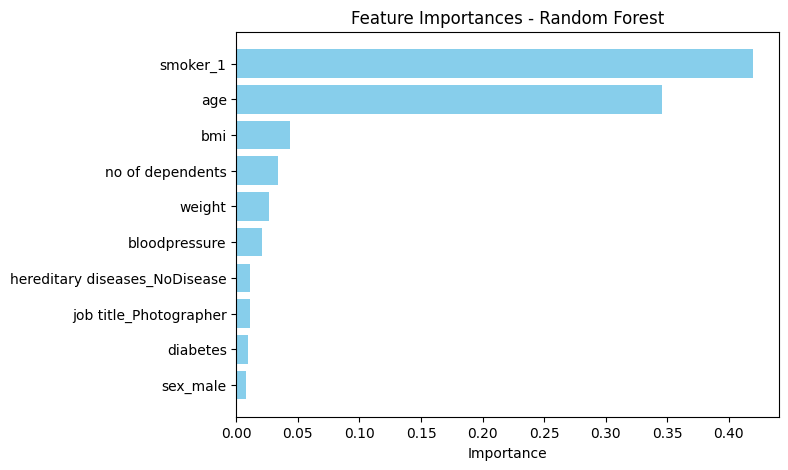

In [57]:

# 9. Öznitelik Önemi (Random Forest)
importances = models["Random Forest"].feature_importances_
indices = np.argsort(importances)[-10:]
features = X.columns

plt.figure(figsize=(7, 5))
plt.title("Feature Importances - Random Forest")
plt.barh(range(len(indices)), importances[indices], color="skyblue", align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Importance")
plt.show()

**Öznitelik Önemlerinin Görselleştirilmesi (Random Forest)**

Random Forest modeli tarafından öğrenilen en önemli 10 özelliği gösterir.
Bu, hangi değişkenlerin tahminlerde daha etkili olduğunu anlamamıza yardımcı olur.



# 10. Görselleştirme



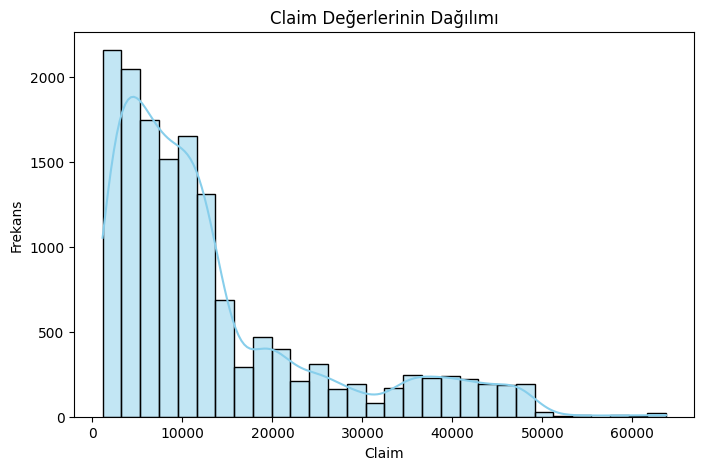

In [58]:

# Claim Dağılımı
plt.figure(figsize=(8, 5))
sns.histplot(df['claim'], bins=30, kde=True, color='skyblue')
plt.title("Claim Değerlerinin Dağılımı")
plt.xlabel("Claim")
plt.ylabel("Frekans")
plt.show()


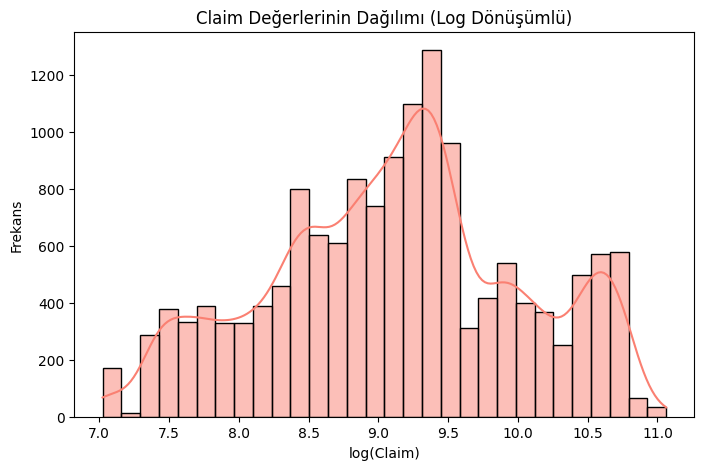

In [59]:
# Log Dönüşümlü Claim Dağılımı
plt.figure(figsize=(8, 5))
sns.histplot(df['claim_log'], bins=30, kde=True, color='salmon')
plt.title("Claim Değerlerinin Dağılımı (Log Dönüşümlü)")
plt.xlabel("log(Claim)")
plt.ylabel("Frekans")
plt.show()

**Veri Dağılımlarının Görselleştirilmesi**

Claim değerlerinin orijinal ve log dönüşümlü dağılımları karşılaştırıldı.
Log dönüşümünün veriyi daha simetrik hale getirdiği, aşırı büyük değerlerin etkisini azalttığı görülür.

In [60]:

# Korelasyonları hesapla
correlation = df.corr(numeric_only=True)

# claim_log ile en yüksek korelasyona sahip ilk 10 değişkeni al
top_corr = correlation['claim_log'].sort_values(ascending=False)[1:11]  # ilk satır claim_log'un kendisidir

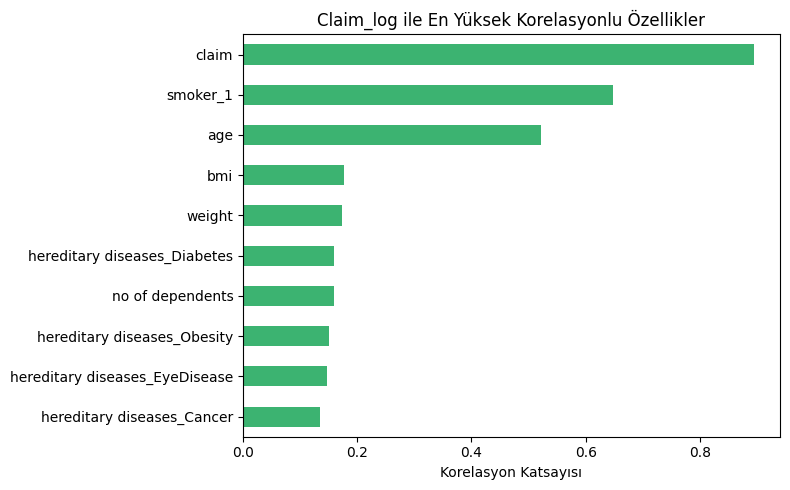

In [61]:
# Bar grafik olarak çiz
plt.figure(figsize=(8, 5))
top_corr.plot(kind='barh', color='mediumseagreen')
plt.xlabel("Korelasyon Katsayısı")
plt.title("Claim_log ile En Yüksek Korelasyonlu Özellikler")
plt.gca().invert_yaxis()  # En büyük yukarıda gözüksün
plt.tight_layout()
plt.show()

* Korelasyon, iki değişken arasındaki doğrusal ilişkinin gücünü belirtir.
Bu analiz, hedefi en çok etkileyen faktörleri ortaya çıkarır.


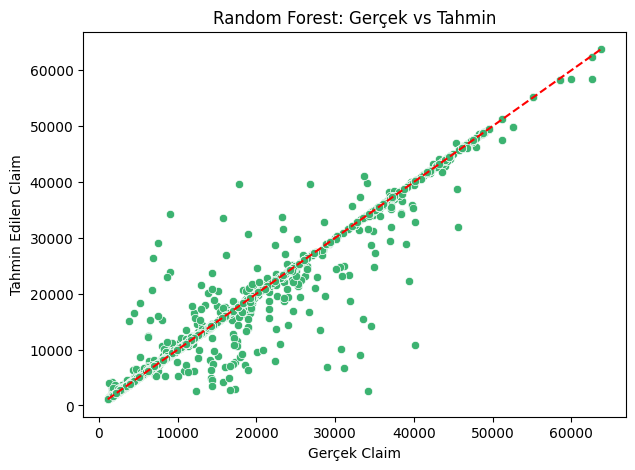

In [62]:
# Scatter Plot: Random Forest
y_test_exp, y_pred_exp = results["Random Forest"]
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test_exp, y=y_pred_exp, color="mediumseagreen")
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--')
plt.xlabel("Gerçek Claim")
plt.ylabel("Tahmin Edilen Claim")
plt.title("Random Forest: Gerçek vs Tahmin")
plt.show()

**Random Forest Modeli Tahminlerinin Gerçek Değerlerle Karşılaştırılması**

Gerçek ve modelin tahmin ettiği claim değerlerinin karşılaştırıldığı scatter plot.
Kırmızı kesikli çizgi, mükemmel tahminin olduğu yerdir (gerçek = tahmin).
Noktaların bu çizgiye ne kadar yakın olduğu, modelin başarısını görsel olarak gösterir.


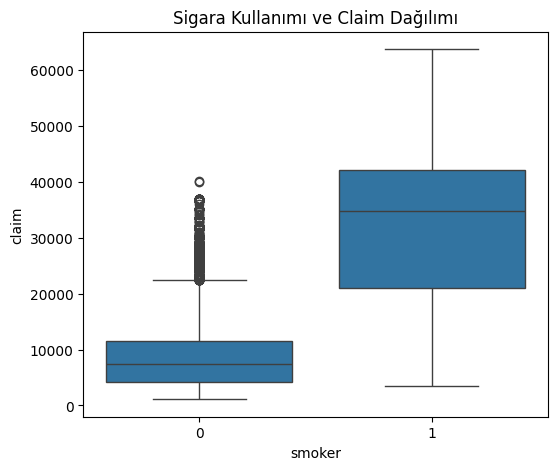

In [63]:
# Sigara - Claim
plt.figure(figsize=(6, 5))
df_raw = pd.read_csv("healthinsurance.csv", sep=";")
sns.boxplot(x='smoker', y='claim', data=df_raw)
plt.title("Sigara Kullanımı ve Claim Dağılımı")
plt.show()

**Sigara Kullanımı ve Claim Dağılımı Analizi**

Sigara kullanan ve kullanmayanların sigorta taleplerinin dağılımı karşılaştırıldı.
Boxplot, medyan, çeyrekler ve uç değerleri görmeyi sağlar.
Bu analiz, sigara kullanımının sağlık sigortası talepleri üzerindeki etkisini ortaya koyar.

# **Yorum ve Sonuç**

* Random Forest, tüm modeller içinde en düşük MAE ve RMSE değerlerine sahip. Bu, tahminlerin ortalama olarak gerçek taleplere çok yakın olduğunu gösterir. Ayrıca R² skoru 0.965 ile çok yüksek; yani model veri setindeki varyansın %96,5’ini açıklayabiliyor. Bu da yüksek doğruluk anlamına gelir.

* XGBoost performansı da iyi olmakla birlikte Random Forest kadar düşük hata oranlarına ulaşamamış. R² değeri hala yüksek (0.948), ancak hata metriklerinde Random Forest’ın gerisinde.

* Gradient Boosting, diğer topluluk modellerine kıyasla daha düşük başarı gösteriyor. Hata değerleri yüksek ve R² düşmüş durumda (0.843). Bu da modelin veriyi yeterince iyi öğrenemediğini gösteriyor.

* Ridge ve Lasso regresyon modelleri, basit doğrusal modeller oldukları için veri setindeki karmaşık ve doğrusal olmayan ilişkileri yakalayamıyorlar. Özellikle Lasso’nun R² değeri çok düşük (0.015), yani pratikte veri setini açıklamada başarısız olduğu söylenebilir.

**Model Seçiminde Neden Random Forest?**

* Karmaşık ilişkileri başarıyla öğreniyor: Sağlık sigortası verisi, farklı kategorik ve sayısal özelliklerin etkileşiminden oluşur. Random Forest, bu karmaşıklığı yakalayabilen bir modeldir.
* Genel performans üstünlüğü: En düşük hata metrikleri ve en yüksek açıklama gücüne sahiptir.
* Genelleme yeteneği yüksek: Test setindeki başarısı, modeli yeni verilerde de başarılı kılma potansiyelini gösteriyor.
* Aşırı öğrenmeye karşı dayanıklı: Çok sayıda karar ağacının birleşmesi ile modelin aşırı öğrenme (overfitting) yapma riski azalır.
